# Fine Tune Embeddings for RAG
* Notebook by Adam Lang
* Date: 3/28/2025

# Overview
* In this notebook we will fine tune an embedding model using a dataset from hugging face that was pre-built for optimizing RAG.
* This was inspired by an AI Makerspace webinar.

# Import Dependencies

## Nest Asyncio
* We will use this to leverage async loops within the notebook.
* `nest_asyncio` is a Python library designed to modify the behavior of the `asyncio` modue.
* This allows for **nested event loops.**
  * By default, `asyncio` **does not support nesting event loops**, which can lead to issues in environments where an event loop is already running, such as:
    * Web servers (e.g., Flask, FastAPI, Django)
    * GUI applications
    * Jupyter notebooks

In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
%%capture
!pip install langchain_openai langchain_huggingface langchain_core langchain langchain_community

In [3]:
%%capture
!pip install unstructured faiss-cpu

# Setup OpenAI API Key and Environment Variable

In [4]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass("Enter OpenAI API Key: ")

Enter OpenAI API Key: ··········


# Data Loading
* We will get a dataset to work with.
* The specific dataset is the Elon Musk-Lex Friedman transcript that was downloaded and preprocessed and stored in this repo.

In [5]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

fatal: destination path 'DataRepository' already exists and is not an empty directory.


In [6]:
%cd DataRepository

/content/DataRepository


## Data Loading with UnstructuredHTMLLoader
* The HTML Loader in LangChain is specifically designed to simplify the process of loading HTML content into your applications.
* Why would you use this?

1. **Simplicity**
  * abstracts low-level details, allowing you to focus on other more important things.

2. **Flexibility**
  * Supports loading multiple HTML formats.

3. **Integration**
  * Seamless integration with other components in the LangChain ecosystem, such as document loaders and transformers.

4. **Performance**
  * Very fast and efficient for BIG datasets.




In [7]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

## load data file from repo
train_docs_loaded = UnstructuredHTMLLoader("elon_lex_transcript.html.html")

## Split and Chunk Documents

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

## setup text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=750,
    chunk_overlap=20,
    length_function=len,
)

## split and chunk the document
train_docs = text_splitter.split_documents(train_docs_loaded.load())

In [9]:
## len of chunked docs
len(train_docs)

963

## UUIDs
* UUIDs (Universally Unique Identifiers) are used in Python to generate unique identifiers, ensuring that no two objects or records, even across different systems or databases, will have the same ID.
* This is particularly useful in distributed systems, database management, and situations where avoiding ID collisions is crucial.
* UUIDs are 128-bit values, typically represented as 32 hexadecimal digits, grouped into five sections separated by hyphens.
* The uuid module in Python provides functions for generating different versions of UUIDs, each with its own method of creation.

In [10]:
import uuid

## create id set
id_set = set()

## loop over training docs and assign unique ids
for doc in train_docs:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  doc.metadata['id'] = id

## Train-Test-Validation Split
* We will split this data into train-test-validation sets.

In [11]:
## train documents - 300 examples
train_split_docs = train_docs[:300]

## val documents - 50 examples
val_split_docs = train_docs[300:350]

## test documents - 50 test
test_split_docs = train_docs[350:400]

# Building a Fine-Tuning Dataset
* Now we can create a fine-tuning dataset using OpenAI's `gpt-4o-mini` model.

* The concept is:

1. Look at document
2. Generate questions that could be answered by that node

* This will give us a group of question/context pairs that we can use to fine-tune the Embeddings model.

* **Note: You don't have to use this LLM, you could use a model from GROQ or any model of your choice.**

In [12]:
from langchain_openai import ChatOpenAI

## init chat model
qa_chat_model = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0,
)

Question Generation Prompt creation
* Here we construct a prompt that will use `gpt-4o-mini` to generate questions for each retrieved context.
* This is similar to a multi-query retriever approach.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

## prompt creation
qa_prompt = """\
Given the following context, you must generate questions based on the provided context only.

You are to generate {n_questions} questions which should be provided in this format:

1. QUESTION #1
2. QUESTION #2
```

Context:
{context}
```

"""
## setup prompt template
qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

Next, we create a simple LCEL chain to query the LLM.

In [14]:
## chain to query
question_generation_chain = qa_prompt_template | qa_chat_model

### Create Questions Function
* **Note about the `UUID` -- as mentioned this creates universally unique identifiers.**
  * **You could more easily create a hugging face dataset rather than using this function below.**

* Here is what this is going to do:

1. First we provide a list of documents and a number of questions.

2. Then for each document in the list we generate `n_questions` of questions.

3. Then we associate those quetions and contexts via a `UUID`.



In [15]:
import tqdm

## create questions function
def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}
  for document in tqdm.tqdm(documents):
    document_content = {'context': document.page_content, "questions": []}
    questions_generated = question_generation_chain.invoke({'context': document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]
  return questions, relevant_docs

We will use the function to generate training, validation, and test data.

In [16]:
## 1. Generate training data
training_questions, training_relevant_contexts = create_questions(train_split_docs, 2)

100%|██████████| 300/300 [04:24<00:00,  1.14it/s]


In [17]:
## 2. Generate validation data
val_questions, val_relevant_contexts = create_questions(val_split_docs, 2)

100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


In [18]:
## 3. Generate test data
test_questions, test_relevant_contexts = create_questions(test_split_docs, 2)

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Summary
* We created 600 total questions

# Saving the Questions
* We can save the questions locally.

1. Train Dataset

In [19]:
import json

training_corpus = {train_item.metadata['id'] : train_item.page_content for train_item in train_split_docs}

## create train dataset
train_dataset = {
    "questions": training_questions,
    "relevant_contexts": training_relevant_contexts,
    "corpus": training_corpus,
}
## open the file
with open('training_dataset.jsonl', "w") as f:
  f.write(json.dumps(train_dataset))

2. Validation Dataset

In [20]:
val_corpus = {val_item.metadata['id'] : val_item.page_content for val_item in val_split_docs}

## create val dataset
val_dataset = {
    "questions": val_questions,
    "relevant_contexts": val_relevant_contexts,
    "corpus": val_corpus,
}
## open the file
with open('val_dataset.jsonl', "w") as f:
  f.write(json.dumps(val_dataset))

3. Test Dataset

In [21]:
test_corpus = {test_item.metadata['id'] : test_item.page_content for test_item in test_split_docs}

## create test dataset
test_dataset = {
    "questions": test_questions,
    "relevant_contexts": test_relevant_contexts,
    "corpus": test_corpus,
}
## open the file
with open('test_dataset.jsonl', "w") as f:
  f.write(json.dumps(test_dataset))

# Fine-Tuning Embedding Model: `snowflake-artic-embed-m`
* Here is the base embedding model we will fine tune: `Snowflake/snowflake-arctic-embed-m`
  * model card: https://huggingface.co/Snowflake/snowflake-arctic-embed-m

* This model performs well on multiple benchmarks as seen in the model card, but we are going to fine tune the model to our domain specific data.

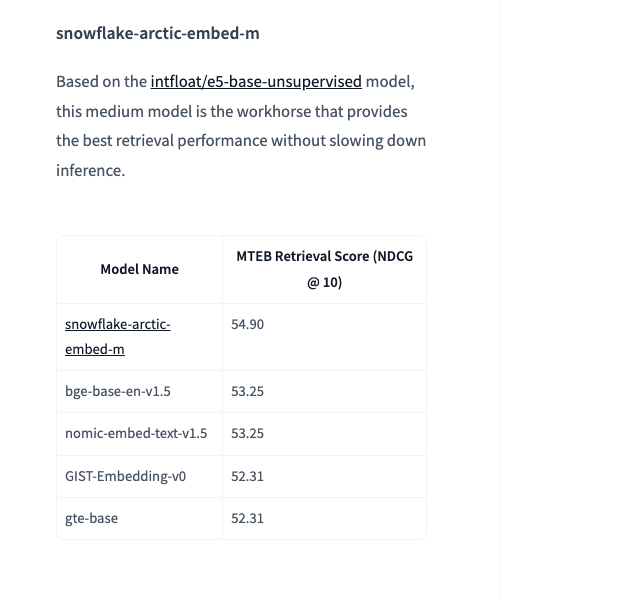

In [22]:
%%capture
!pip install sentence_transformers datasets pyarrow

In [23]:
from sentence_transformers import SentenceTransformer

## load model from hugging face
model_ckpt = 'Snowflake/snowflake-arctic-embed-m'
embed_model = SentenceTransformer(model_ckpt)

## PyTorch Additional Imports

In [24]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

In [25]:
## set batch size -- usually based on multiples of 8
## however, we need a number that works with our data batch sizes
BATCH_SIZE=20

## Format Dataset for Fine Tuning

In [26]:
## formatting
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

## store in list
examples = []
for query_id, query in queries.items():
  ## relevant_docs is a dictionary so we access its elements with brackets [] not parenthesis ()
  doc_id = relevant_docs[query_id][0]
  ## corpus is a dictionary so we access its elements with brackets [] not parenthesis ()
  text = corpus[doc_id]
  example = InputExample(texts=[query, text])
  ## append to list
  examples.append(example)

## Create PyTorch DataLoader

In [27]:
## torch data loader
data_loader = DataLoader(
    examples,
    batch_size=BATCH_SIZE,
)

## Loss Function Setup
* [source](https://medium.com/@aisagescribe/multiple-negative-ranking-loss-mnrl-explained-5b4741e38d8f#:~:text=The%20essence%20of%20MNRL%20is,distance%20with%20multiple%20negative%20samples.)
### MultipleNegativesRankingLoss
* We need to use the `MultipleNegativeRankingLoss` function.
* MNRL fundamentally revolves around a loss function that quantifies the difference between positive and negative samples in relation to a query.
* MNRL creates a clear distinction or classification between **relevant (positive) and irrelevant (negative) data points.**
* This distinction is obtained by **minimizing the distance between the query and positive samples while maximizing the distance with multiple negative samples.**
* **The inclusion of multiple negatives provides a richer context for the model, enabling it to better understand varying degrees of irrelevance or dissimilarity.**

### MatryoshkaLoss
* This is often used in fine-tuning embeddings, is a specialized loss function designed to create "truncatable" embeddings, allowing for efficient storage and processing by truncating embeddings without significant performance loss.

#### Why use Matryoshka Loss?
* Traditional embedding models produce fixed-size vectors, which can be computationally expensive and require significant storage space.
* Matryoshka embeddings allow for variable-sized representations, enabling efficient storage and faster processing.
* This is particularly useful for applications like retrieval, classification, and clustering where storage and processing resources are limited.

### What is most important about Matryoshka Loss?
* This allows us to "front load" our embeddings
* This loss function essentially guides the model to **learn representations where earlier dimensions contain more important information.**
* This allows you to truncate the embedding at various dimensions without significantly impacting performance.
* For example, a Matryoshka model can preserve ~99.9% of its performance while needing 3x less storage!!


In [28]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

## setup ranking loss
matryoshka_dims = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(embed_model)
train_loss = MatryoshkaLoss(
    embed_model,
    inner_train_loss,
    matryoshka_dims=matryoshka_dims,
)

## Setup Evaluator
* We can do this using built-in functions from `SentenceTransformers`.

In [29]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

## init evaluator
evaluator = InformationRetrievalEvaluator(queries,
                                          corpus,
                                          relevant_docs)

Now train the model with 5 epochs.
* This number can be increased the more data you have.

# Train the Model!
* Manually define a warm-up step.
* This will provide a smooth transition to training.

In [30]:
EPOCHS=5

## warm up steps
warmup_steps = int(len(data_loader) * EPOCHS * 0.1)

## fit model for training
embed_model.fit(
    train_objectives=[(data_loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path="./finetuned_arctic_embeddings",
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50,

)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adam-m-lang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
30,No log,No log,0.890000,0.980000,1.000000,1.000000,0.890000,0.326667,0.200000,0.100000,0.890000,0.980000,1.000000,1.000000,0.952340,0.936167,0.936167
50,No log,No log,0.900000,0.990000,0.990000,1.000000,0.900000,0.330000,0.198000,0.100000,0.900000,0.990000,0.990000,1.000000,0.959036,0.945000,0.945000
60,No log,No log,0.910000,0.990000,0.990000,1.000000,0.910000,0.330000,0.198000,0.100000,0.910000,0.990000,0.990000,1.000000,0.964036,0.951667,0.951667
90,No log,No log,0.920000,0.990000,0.990000,1.000000,0.920000,0.330000,0.198000,0.100000,0.920000,0.990000,0.990000,1.000000,0.966418,0.955000,0.955000
100,No log,No log,0.920000,0.990000,0.990000,1.000000,0.920000,0.330000,0.198000,0.100000,0.920000,0.990000,0.990000,1.000000,0.966418,0.955000,0.955000
120,No log,No log,0.920000,0.990000,0.990000,1.000000,0.920000,0.330000,0.198000,0.100000,0.920000,0.990000,0.990000,1.000000,0.966418,0.955000,0.955000
150,No log,No log,0.920000,0.990000,0.990000,1.000000,0.920000,0.330000,0.198000,0.100000,0.920000,0.990000,0.990000,1.000000,0.966418,0.955000,0.955000


# Evaluate the Retriever
* After fine-tuning the embedding model we can evaluate it's precision on the domain specific text.
* We can do this using the **HIT-RATE** metric.

In [31]:
import pandas as pd
from langchain_community.vectorstores import FAISS # vector store
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

In [32]:
## function to eval retrieval process
def eval_retrievers(dataset,
                   embed_model,
                   top_k=5,
                   verbose=False):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={'id': doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  ## init retriever
  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  ## get eval results
  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata['id'] for node in retrieved_nodes]
    # The original line tries to access relevant_docs using the first character of the UUID string,
    # resulting in a KeyError. We need to use the entire UUID string 'id' as the key instead.
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

# Run Head to Head Benchmark Evaluation of 2 embedding models vs. our fine-tuned embedding model
* To do this we can:
1. Evaluate the fine-tuned embedding model against OpenAI's `text-embedding-3-small` embedding model.
2. Evaluate the base **non-fine-tuned version** of the `Snowflake/snowflake-artic-embed-m` model.


## 1. `text-embedding-3-small`

In [33]:
## setup open ai model
te_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te_results = eval_retrievers(test_dataset, te_openai)

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


In [34]:
## save results in df
te_results_df = pd.DataFrame(te_results)

In [35]:
## calculate mean hit rate for OpenAI model
te_hit_rate = te_results_df['is_hit'].mean()
print(f"Hit Rate for OpenAI text-embedding-3-small is: {te_hit_rate}")

Hit Rate for OpenAI text-embedding-3-small is: 1.0


Summary
* We can see a HIT RATE of 1.0 which is what we want to see for any retrieval model.

## 2. `Snowflake/snowflake-artic-embed-m` base model
* Eval the base model that was NOT fine tuned.

In [36]:
from langchain_huggingface import HuggingFaceEmbeddings

## load model
snowflake_base_model = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m")

## get results
snowflake_embed_base_model_results = eval_retrievers(test_dataset, snowflake_base_model)

100%|██████████| 100/100 [00:01<00:00, 86.75it/s]


In [37]:
## store in results df
snowflake_embed_m_results_df = pd.DataFrame(snowflake_embed_base_model_results)

In [38]:
## get hit rate
snowflake_embed_m_hit_rate = snowflake_embed_m_results_df['is_hit'].mean()
print(f"Snowflake artic embed-m base model hit rate: {snowflake_embed_m_hit_rate}")

Snowflake artic embed-m base model hit rate: 0.67


Summary
* The base model for artic embed shows us the hit rate is 0.66 which is not ideal for our domain specific data and definitely not as perfect as the 1.0 for OpenAI model.

## 3. `Snowflake/snowflake-artic-embed-m` finetuned embedding model
* Now the moment of truth lets evaluate the model we just fine-tuned with MNR and Matryoshka loss on the domain specific data.

In [39]:
## load fine tuned model
finetune_embeds = HuggingFaceEmbeddings(model_name='/content/DataRepository/finetuned_arctic_embeddings')
finetune_results = eval_retrievers(test_dataset, finetune_embeds)

Some weights of BertModel were not initialized from the model checkpoint at /content/DataRepository/finetuned_arctic_embeddings and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [00:01<00:00, 86.20it/s]


In [40]:
## save results to df
finetune_results_df = pd.DataFrame(finetune_results)

In [41]:
## get hit rate for finetuned model
finetune_hit_rate = finetune_results_df['is_hit'].mean()
print(f"Finetuned Snowflake artic-m embed model hit rate: {finetune_hit_rate}")

Finetuned Snowflake artic-m embed model hit rate: 0.99


Summary
* Aha! We can see fine tuning did improve the hit rate on our domain specific data with a hit rate of 0.99, much improved from the base model hit rate of 0.66.

# Re-evaluate RAG Pipeline
* Lets use the RAG pipeline above to check some of the chunk retrieval using the fine tuned model.

## Creating New Chunks
* Create new chunks to evaluate with.

In [42]:
## setup text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=50,
    length_function=len,
)
## train docs
train_docs = text_splitter.split_documents(train_docs_loaded.load())

# Setup Base Chain
* This will use the untrained retrieval model which is the base snowflake-artic-m model before we fine tuned it.

## R- Retrieval

In [43]:
from langchain_community.vectorstores import FAISS

## init vectorstore
base_vectorstore = FAISS.from_documents(train_docs, snowflake_base_model)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

## A - Augmented

In [44]:
from langchain_core.prompts import ChatPromptTemplate

## prompt setup
RAG_PROMPT = """\
Given a provided context and a question, you need to answer the question.
If you do not know the answer just say "I don't know".

Context:
{context}

Question:
{question}

Answer:
"""
## prompt template for RAG
rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

## G - Generation

In [45]:
## setup generation pipeline
rag_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

# Build RAG-LCEL Pipeline

In [46]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

## setup base rag chain
base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [47]:
## run the base rag chain
base_rag_chain.invoke({"question": "What is Ayahuasca?"})['response']

"I don't know."

In [48]:
## run base rag chain with real question from document data
base_rag_chain.invoke({"question": "What is the difference between Neurosurgery and Neuralink surgery?"})['response']

'Neurosurgery typically involves more invasive procedures, such as opening up deeper parts of the brain or manipulating blood vessels, which carries significant risks. In contrast, Neuralink surgery involves cortical micro-insertions that are less invasive, as they only require openings on the surface of the brain, thus carrying significantly less risk compared to traditional neurosurgeries like tumor or aneurysm surgeries. Additionally, Neuralink surgery utilizes advanced robotic technology and extensive practice to ensure precision in electrode insertion, which may differ from standard neurosurgical practices.'

In [49]:
##test again
base_rag_chain.invoke({"question": "What is Neural Dust?"})['response']

"I don't know."

In [50]:
## test again
base_rag_chain.invoke({"question": "What is a Neural Decoder?"})['response']

'A Neural Decoder is a system or model that interprets neural signals, such as sequences of spikes from neurons, to extract meaningful information or predict certain outcomes. It involves machine learning techniques to create a mapping between the neural data and the labels or actions they represent. The process includes challenges related to architecture design, hyperparameter optimization, and ensuring software stability and reliability.'

# Fine-Tuned Embedding Model RAG Pipeline
* Now we lets demo the domain specific fine tuned embedding model on the RAG pipeline and see the results.

In [51]:
## setup vector store and retriever
finetune_vectorstore = FAISS.from_documents(train_docs, finetune_embeds)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [52]:
## finetune RAG
finetune_RAG_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [53]:
## test finetuned rag chain
finetune_RAG_chain.invoke({"question": "What is Ayahuasca?"})['response']

'Ayahuasca is a psychoactive brew made from the Banisteriopsis caapi vine and other plants, traditionally used in South American shamanic practices for spiritual and healing purposes. It contains DMT (dimethyltryptamine), a powerful hallucinogenic compound.'

In [54]:
## test again
finetune_RAG_chain.invoke({"question": "What is the difference between Neurosurgery and Neuralink surgery?"})['response']

'Neurosurgery typically involves more invasive procedures that may include opening deeper parts of the brain or manipulating blood vessels, which carries significant risks. In contrast, Neuralink surgery focuses on cortical micro-insertions on the surface of the brain, which is considered to carry significantly less risk compared to traditional neurosurgeries like tumor or aneurysm surgeries. Additionally, Neuralink surgery utilizes advanced robotic technology and extensive practice to ensure precision and safety during the procedure.'

In [55]:
## test again
finetune_RAG_chain.invoke({"question": "What is Neural Dust, what does it do?"})['response']

'Neural Dust refers to a system that involves tiny, implantable devices about the size of a neuron. These devices are designed to be placed next to neurons to record their state and communicate that information back to the outside world. The initial goal of the project was to use ultrasound for powering and communication, rather than electromagnetic waves, allowing for effective interaction with neural activity.'

In [56]:
## test again
finetune_RAG_chain.invoke({"question": "What is a Neural Decoder"})['response']

'A Neural Decoder is a system or algorithm that interprets and translates the electrical signals (spikes) generated by neurons in the brain into meaningful information or actions. It involves processing the raw data from brain activity to understand what those signals represent, which can be used for various applications, such as controlling devices or understanding brain functions.'

In [57]:
## test again
finetune_RAG_chain.invoke({"question": "Who got Neuralink surgery?"})['response']

'Noland Arbaugh was the first human participant to receive a Neuralink implant.'